In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from sklearn.metrics import r2_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version_)

In [2]:
# Load and clean the dataset
df = pd.read_csv('C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/MortData/GertPollMortAll.csv', sep=';', header=0, index_col=0, parse_dates=True)

In [3]:
# Drop rows with any NaN values
df_cleaned = df.dropna()

In [4]:
# Separate target variable (mortality) and use everything else as features
target = 'death_count'
features = df_cleaned.drop(columns=[target])

In [5]:
# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

In [6]:
# Step 2: Prepare the Data for LSTM
def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])  # Predict next day's mortality
    return np.array(X), np.array(y)

n_steps = 30  # 30 days look-back for daily data
X, y = create_sequences(scaled_features, scaled_target, n_steps)

In [7]:
# Reshape the data to fit LSTM input format (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [8]:
# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
# Step 3: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(n_steps, X.shape[2])))
model.add(Dense(50, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


C:\Users\User\anaconda3\envs\MyChatBot\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Step 4: Train the Model
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0563
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0219
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0218
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0202
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0203
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0200
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0195
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0204
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0195
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0189
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0187
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0184
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0191
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0185
Epoch 15/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0177
Epoc

In [11]:
# Step 5: Make Predictions for Daily Mortality
daily_predictions = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 


In [12]:
# Inverse transform the predictions to the original mortality scale
daily_predictions_rescaled = scaler_target.inverse_transform(daily_predictions)

In [13]:
# Step 6: Aggregate Daily Predictions to Monthly Predictions
df_predictions = pd.DataFrame({'date': df_cleaned.index[-len(daily_predictions_rescaled):], 'predicted_mortality': daily_predictions_rescaled.flatten()})
df_predictions.set_index('date', inplace=True)

# Sum daily predictions by month
monthly_predictions = df_predictions.resample('M').sum()

C:\Users\User\AppData\Local\Temp\ipykernel_12408\66990188.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_predictions = df_predictions.resample('M').sum()


In [14]:
# Inverse transform y_test to get the actual mortality values for the test set
y_test_rescaled = scaler_target.inverse_transform(y_test)


In [15]:
# Get the date range corresponding to the test set
test_dates = df_cleaned.index[-len(y_test_rescaled):]

In [16]:
# Create a DataFrame for y_test with the appropriate date index
df_actual_test = pd.DataFrame({
    'actual_mortality': y_test_rescaled.flatten()
}, index=test_dates)


In [17]:
# Resample the actual test values by month to get monthly sums
df_actual_monthly = df_actual_test.resample('M').sum()


C:\Users\User\AppData\Local\Temp\ipykernel_12408\1112903555.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_actual_monthly = df_actual_test.resample('M').sum()


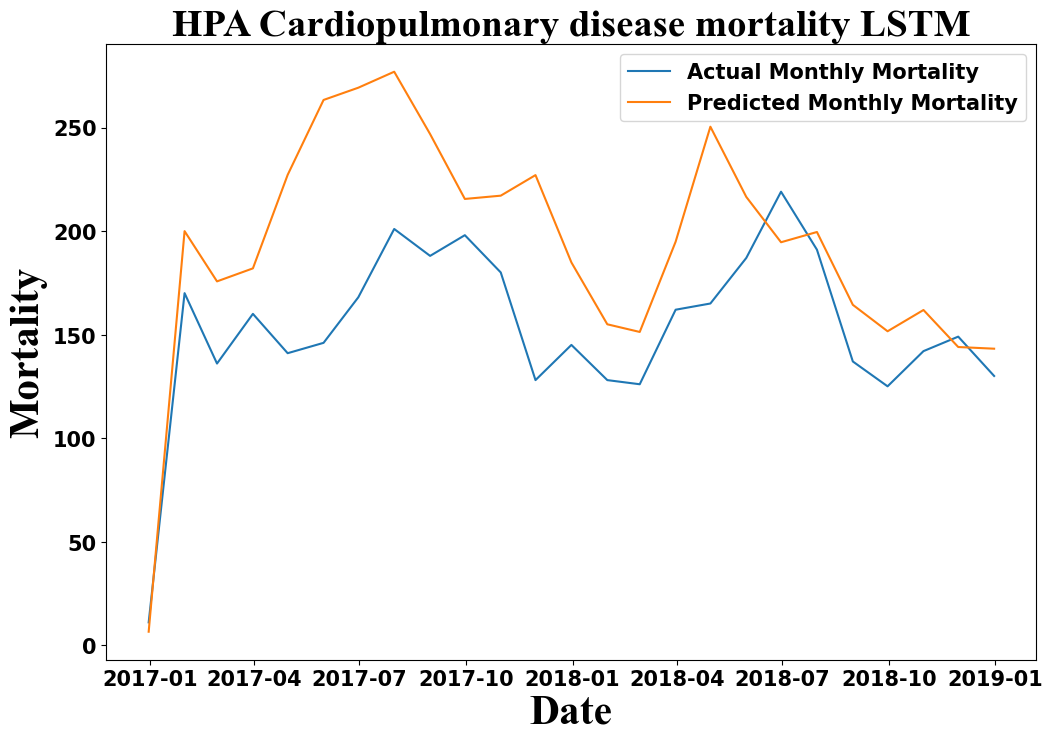

In [18]:
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = '15'
plt.figure(figsize=(12, 8))

# Plot actual vs predicted monthly mortality
plt.plot(df_actual_monthly.index, df_actual_monthly.values, label='Actual Monthly Mortality')
plt.plot(monthly_predictions.index, monthly_predictions['predicted_mortality'].values, label='Predicted Monthly Mortality')

# Customize the x-axis labels
#plt.xticks(rotation=90)

plt.ylabel('Mortality', fontname="Times New Roman", size=30, fontweight="bold")
plt.xlabel('Date', fontname="Times New Roman", size=30, fontweight="bold")
plt.title('HPA Cardiopulmonary disease mortality LSTM', fontname="Times New Roman", size=28, fontweight="bold")

# Set legend properties
legend_properties = {'weight': 'bold'}
plt.legend(prop=legend_properties)

plt.show()

In [19]:
mean_absolute_error(df_actual_monthly, monthly_predictions)

42.15824457168579

In [20]:
rmse = sqrt(mean_squared_error(df_actual_monthly, monthly_predictions))
print(rmse)

52.92656515410574


In [21]:
r2_score(df_actual_monthly, monthly_predictions)

-0.8227889962814399

# LSTM FOR SHAP

C:\Users\User\anaconda3\envs\MyChatBot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 70s 8ms/step 


  1%|          | 1/100 [01:19<2:11:13, 79.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 66s 7ms/step 


  2%|▏         | 2/100 [02:33<2:04:40, 76.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step 


  3%|▎         | 3/100 [03:57<2:08:48, 79.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


  4%|▍         | 4/100 [05:20<2:09:56, 81.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


  5%|▌         | 5/100 [06:44<2:09:53, 82.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step


  6%|▌         | 6/100 [08:07<2:09:15, 82.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step


  7%|▋         | 7/100 [09:12<1:58:41, 76.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step


  8%|▊         | 8/100 [10:35<2:00:50, 78.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step 


  9%|▉         | 9/100 [11:59<2:01:52, 80.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 10%|█         | 10/100 [12:57<1:50:20, 73.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 11%|█         | 11/100 [14:21<1:53:36, 76.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 12%|█▏        | 12/100 [15:44<1:55:24, 78.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 13%|█▎        | 13/100 [17:08<1:56:11, 80.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 14%|█▍        | 14/100 [18:04<1:44:34, 72.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 15%|█▌        | 15/100 [19:28<1:47:50, 76.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 16%|█▌        | 16/100 [20:51<1:49:39, 78.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 17%|█▋        | 17/100 [22:14<1:50:28, 79.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 18%|█▊        | 18/100 [23:38<1:50:36, 80.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 19%|█▉        | 19/100 [25:01<1:50:18, 81.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 20%|██        | 20/100 [26:25<1:49:40, 82.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 21%|██        | 21/100 [27:48<1:48:48, 82.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 22%|██▏       | 22/100 [29:12<1:47:44, 82.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 23%|██▎       | 23/100 [30:08<1:36:05, 74.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 24%|██▍       | 24/100 [31:32<1:38:06, 77.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step


 25%|██▌       | 25/100 [32:55<1:39:03, 79.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 26%|██▌       | 26/100 [34:18<1:39:17, 80.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 27%|██▋       | 27/100 [35:15<1:29:22, 73.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 28%|██▊       | 28/100 [36:11<1:21:52, 68.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 29%|██▉       | 29/100 [37:35<1:26:09, 72.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 30%|███       | 30/100 [38:31<1:18:53, 67.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 31%|███       | 31/100 [39:54<1:23:15, 72.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 32%|███▏      | 32/100 [41:18<1:25:48, 75.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 33%|███▎      | 33/100 [42:41<1:27:08, 78.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 34%|███▍      | 34/100 [43:36<1:18:16, 71.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 35%|███▌      | 35/100 [44:32<1:12:11, 66.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step


 36%|███▌      | 36/100 [45:27<1:07:20, 63.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step


 37%|███▋      | 37/100 [46:51<1:12:42, 69.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step


 38%|███▊      | 38/100 [48:14<1:15:58, 73.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step


 39%|███▉      | 39/100 [49:38<1:17:48, 76.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 40%|████      | 40/100 [50:35<1:10:40, 70.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 41%|████      | 41/100 [51:31<1:05:09, 66.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 42%|████▏     | 42/100 [52:27<1:01:08, 63.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 43%|████▎     | 43/100 [53:24<58:23, 61.46s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 44%|████▍     | 44/100 [54:48<1:03:31, 68.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step


 45%|████▌     | 45/100 [55:42<58:42, 64.04s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 46%|████▌     | 46/100 [57:06<1:02:54, 69.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 47%|████▋     | 47/100 [58:01<57:57, 65.61s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 48%|████▊     | 48/100 [59:25<1:01:31, 70.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 49%|████▉     | 49/100 [1:00:22<56:44, 66.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 50%|█████     | 50/100 [1:01:45<59:48, 71.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 51%|█████     | 51/100 [1:03:09<1:01:28, 75.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 52%|█████▏    | 52/100 [1:04:32<1:02:11, 77.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 53%|█████▎    | 53/100 [1:05:56<1:02:13, 79.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 54%|█████▍    | 54/100 [1:07:19<1:01:49, 80.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 55%|█████▌    | 55/100 [1:08:43<1:01:16, 81.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 56%|█████▌    | 56/100 [1:10:07<1:00:18, 82.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 57%|█████▋    | 57/100 [1:11:30<59:11, 82.60s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 58%|█████▊    | 58/100 [1:12:54<57:59, 82.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 59%|█████▉    | 59/100 [1:14:17<56:43, 83.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 60%|██████    | 60/100 [1:15:14<50:11, 75.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 61%|██████    | 61/100 [1:16:13<45:36, 70.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 62%|██████▏   | 62/100 [1:17:09<41:51, 66.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 63%|██████▎   | 63/100 [1:18:06<38:58, 63.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 64%|██████▍   | 64/100 [1:19:29<41:34, 69.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 65%|██████▌   | 65/100 [1:20:53<42:53, 73.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step


 66%|██████▌   | 66/100 [1:22:16<43:20, 76.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 67%|██████▋   | 67/100 [1:23:39<43:12, 78.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step


 68%|██████▊   | 68/100 [1:25:03<42:41, 80.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 69%|██████▉   | 69/100 [1:26:26<41:53, 81.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 70%|███████   | 70/100 [1:27:22<36:48, 73.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 71%|███████   | 71/100 [1:28:19<33:08, 68.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 72%|███████▏  | 72/100 [1:29:16<30:24, 65.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 73%|███████▎  | 73/100 [1:30:40<31:47, 70.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step


 74%|███████▍  | 74/100 [1:32:03<32:16, 74.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step


 75%|███████▌  | 75/100 [1:33:05<29:27, 70.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step


 76%|███████▌  | 76/100 [1:34:07<27:14, 68.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 77%|███████▋  | 77/100 [1:35:31<27:52, 72.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 78%|███████▊  | 78/100 [1:36:30<25:09, 68.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 79%|███████▉  | 79/100 [1:37:53<25:34, 73.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 80%|████████  | 80/100 [1:39:17<25:23, 76.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step


 81%|████████  | 81/100 [1:40:40<24:48, 78.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 82%|████████▏ | 82/100 [1:42:03<23:57, 79.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 83%|████████▎ | 83/100 [1:43:27<22:56, 80.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step


 84%|████████▍ | 84/100 [1:44:50<21:47, 81.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 85%|████████▌ | 85/100 [1:45:49<18:40, 74.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 86%|████████▌ | 86/100 [1:47:12<18:02, 77.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 87%|████████▋ | 87/100 [1:48:36<17:09, 79.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step


 88%|████████▊ | 88/100 [1:49:32<14:28, 72.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step


 89%|████████▉ | 89/100 [1:50:56<13:52, 75.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 90%|█████████ | 90/100 [1:52:19<12:59, 78.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 91%|█████████ | 91/100 [1:53:18<10:51, 72.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step


 92%|█████████▏| 92/100 [1:54:23<09:19, 70.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 93%|█████████▎| 93/100 [1:55:20<07:43, 66.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 94%|█████████▍| 94/100 [1:56:43<07:07, 71.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step


 95%|█████████▌| 95/100 [1:58:07<06:14, 74.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 96%|█████████▌| 96/100 [1:59:05<04:40, 70.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 97%|█████████▋| 97/100 [2:00:29<03:42, 74.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 98%|█████████▊| 98/100 [2:01:52<02:33, 76.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step


 99%|█████████▉| 99/100 [2:03:15<01:18, 78.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step


100%|██████████| 100/100 [2:04:39<00:00, 74.79s/it]


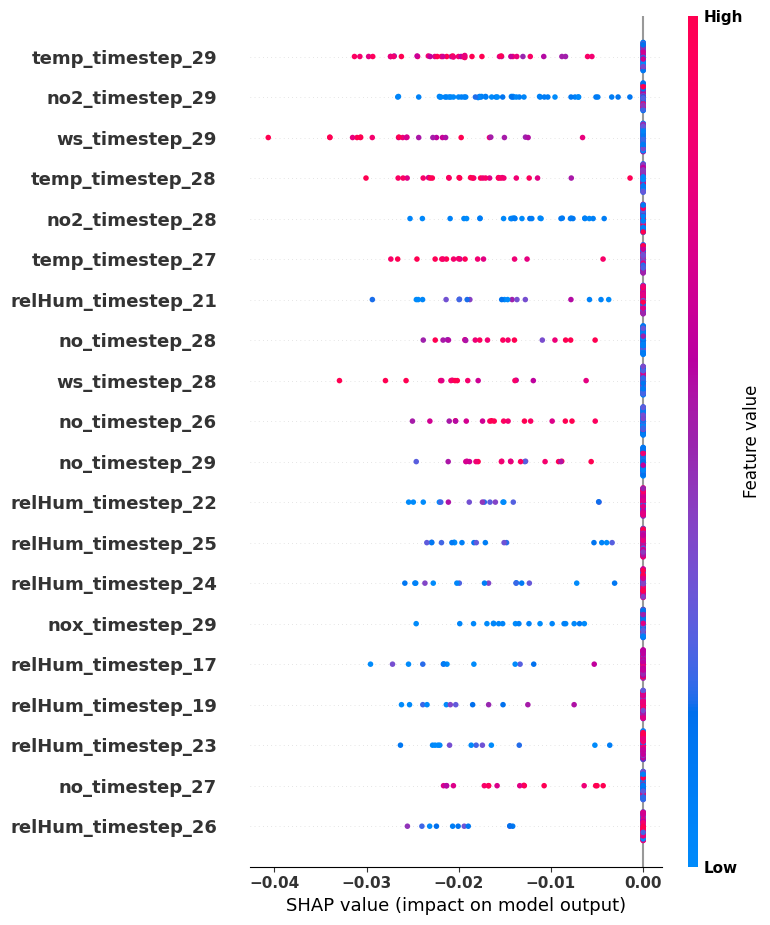

In [22]:
import shap
import numpy as np

# Sample a subset of the test set (SHAP is computationally expensive)
#X_test_sample = X_test[:10]  # Use a small sample for demonstration (First 10)
X_test_sample = X_test[np.random.choice(X_test.shape[0], 100, replace=False)] #(random 10)

# Reshape the 3D data into 2D for SHAP (flatten time steps and features)
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_sample_flattened = X_test_sample.reshape((X_test_sample.shape[0], X_test_sample.shape[1] * X_test_sample.shape[2]))

# Create a SHAP KernelExplainer using the model's prediction function
explainer = shap.KernelExplainer(
    lambda x: model.predict(x.reshape((x.shape[0], n_steps, X.shape[2]))).reshape(-1),  # Ensure the output is 1D
    X_train_flattened[:100]
)

# Calculate SHAP values for the test sample
shap_values = explainer.shap_values(X_test_sample_flattened)

# Feature names (flattened time steps and features)
flattened_feature_names = [f"{feature}_timestep_{i}" for i in range(n_steps) for feature in features.columns]

# Ensure the length of feature names matches the number of features
assert len(flattened_feature_names) == X_test_sample_flattened.shape[1], "Feature names length mismatch."

# Plot summary plot of SHAP values
shap.summary_plot(shap_values, X_test_sample_flattened, feature_names=flattened_feature_names)

# LSTM WITH ATTENTION

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0947
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0217
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0225
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0210
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0204
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0202 
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0217
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0202
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0213
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0207
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0203
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0200
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0197
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0200
Epoch 15/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0205
Epo

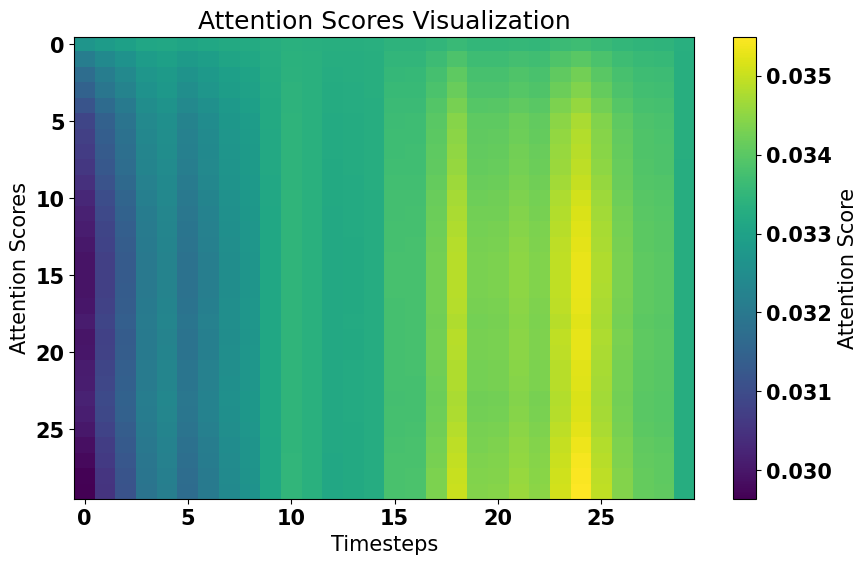

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten, Dot, Softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the attention mechanism
def attention_layer(inputs):
    query = Dense(1, use_bias=False)(inputs)  # Query layer
    keys = Dense(1, use_bias=False)(inputs)   # Key layer
    values = Dense(1, use_bias=False)(inputs) # Value layer

    # Compute attention scores
    scores = Dot(axes=[2, 2])([query, keys])  # Shape: (batch_size, n_steps, 1)
    scores = Softmax()(scores)  # Normalize scores
    context_vector = Dot(axes=[1, 1])([scores, values])  # Shape: (batch_size, 1, features)

    return context_vector, scores

# Define the model
def build_model(n_steps, n_features):
    inputs = Input(shape=(n_steps, n_features))
    x = LSTM(50, return_sequences=True)(inputs)
    context_vector, attention_scores = attention_layer(x)  # Apply attention mechanism and capture scores
    x = Flatten()(context_vector)
    x = Dense(50, activation='relu')(x)
    outputs = Dense(1)(x)  # Output is just the prediction
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model, attention_scores  # Return attention scores for later use

# Load and preprocess data
df = pd.read_csv('C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/MortData/GertPollMortAll.csv', sep=';', header=0, index_col=0, parse_dates=True)
df_cleaned = df.dropna()
target = 'death_count'
features = df_cleaned.drop(columns=[target])

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

# Create sequences
def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(scaled_features, scaled_target, n_steps)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the model
model, attention_scores = build_model(n_steps, X.shape[2])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Rescale the predictions
daily_predictions_rescaled = scaler_target.inverse_transform(predictions)

# Evaluate the model to get attention scores
example_input = X_test[:1]  # Use a sample from your test data
attention_model = tf.keras.models.Model(inputs=model.input, outputs=attention_scores)
attention_scores_sample = attention_model.predict(example_input)

# Plot the attention scores
plt.figure(figsize=(10, 6))
plt.imshow(attention_scores_sample[0], aspect='auto', cmap='viridis')
plt.colorbar(label='Attention Score')
plt.xlabel('Timesteps')
plt.ylabel('Attention Scores')
plt.title('Attention Scores Visualization')
plt.show()


Interpreting the attention scores plot is a great way to understand how your model is focusing on different time steps. Here’s how you can make sense of it:

Heatmap Colors: The colors on the heatmap represent the attention scores, ranging from low to high values. Typically, a color gradient (like yellow to purple in viridis colormap) indicates this range. Brighter colors (closer to yellow) suggest higher attention scores, meaning the model is paying more attention to those time steps. Darker colors (closer to purple) indicate lower attention scores.

X-axis (Timesteps): This axis represents the sequence of time steps in your input data. For example, if you’re using 30 time steps in each input sequence, the x-axis will range from 1 to 30.

Y-axis (Attention Scores): This axis shows the attention scores corresponding to each time step. Since you used a sample input from your test data, this visualizes how much importance the model assigns to each of the 30 time steps for that specific sample.

Understanding Model Focus: By looking at the attention scores, you can determine which time steps had the most significant impact on the model’s prediction. High attention scores at certain timesteps suggest those periods are particularly informative or influential in making the prediction.

Practical Insight:
Clusters of High Attention: If you see clusters of bright colors, it implies that the model is focusing on specific periods in your time series data.

Consistent High Attention: If high attention is spread evenly across several time steps, it suggests that the model considers all these steps equally important for making predictions.

Patterns: Look for patterns in the attention scores to see if the model’s focus changes over time in a meaningful way that correlates with known events or trends in your data.